In [ ]:
import warnings
from configparser import ConfigParser

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from easydict import EasyDict
from matplotlib import ticker
from pytorch_lightning import seed_everything
from tqdm.contrib import tenumerate

from models.protoconv.comet_connector import CometConnector

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.4)
pd.set_option('display.max_rows', 110)

flips_col_name = 'Percentage of decisions changed'
phrases_col_name = 'Number of iterations'
dataset_col_name = 'Dataset'

warnings.simplefilter("ignore")
seed_everything(0)

In [10]:
@torch.no_grad()
def calc_decision_flips(model, val_loader, iterations=3, random=False):
    context = model.conv_filter_size // 2
    decision_flips = [0] * iterations
    all_tests = 0

    for batch_id, (text, label) in tenumerate(val_loader, total=len(val_loader)):
        first_decision = model(text).logits.item() > 0
        all_tests += 1

        changed_flag = False

        for test_id in range(iterations):
            if changed_flag:
                decision_flips[test_id] += 1
            else:
                output = model(text)
                similarities = model.dist_to_sim['log'](output.min_distances.squeeze(0))
                evidence = similarities * model.fc1.weight.squeeze(0)
                sorting_indexes = np.argsort(evidence.tolist())
                enabled_prototypes_indexes = [i for i in sorting_indexes if model.enabled_prototypes_mask[i]]

                if first_decision:
                    prototypes_to_remove = [i for i in enabled_prototypes_indexes[::-1] if evidence[i] > 0]
                else:
                    prototypes_to_remove = [i for i in enabled_prototypes_indexes if evidence[i] < 0]

                centers = list(np.random.randint(1, text.shape[1] - 1, len(prototypes_to_remove)))
                for concept_id, concept_to_remove in enumerate(prototypes_to_remove):

                    unk_in_text = 0
                    for word_id in range(text.shape[1]):
                        if text[0, word_id] == TEXT.vocab.stoi['<unk>']:
                            unk_in_text += 1
                    if unk_in_text + 4 >= text.shape[1]:
                        break

                    center = centers[concept_id] if random else torch.argmin(output.distances[0, concept_to_remove]).item()
                    for word_idx in range(center - context, center + context + 1):
                        if 1 <= word_idx <= len(text[0]) - 2:  # dont remove start and stop:
                            text[0, word_idx] = TEXT.vocab.stoi['<unk>']

                    preds = model(text)
                    decision = preds.logits.item() > 0

                    if first_decision != decision:
                        changed_flag = True
                        decision_flips[test_id] += 1
                        break

    print(all_tests)
    for test_id in range(iterations):
        decision_flips[test_id] /= all_tests

    return decision_flips

In [11]:
config = ConfigParser()
config.read('../config.ini')
comet_config = EasyDict(config['cometml'])
commet_connector = CometConnector(comet_config.apikey, comet_config.projectname, comet_config.workspace, rel_path='..')

experimetns_5gram = {
    'imdb': 'abc1851dba1c46f28e16ddd90ec9c3e6',
    'amazon': 'e81f6bb0081f459c8e5c2b42cae6a2ea',
    'yelp': '26daecaeebd246a9ac9c14bdbafcc1fe',
    'rottentomatoes': '6b4aef88e5144aa396f4eef98490e3a7',
    'hotel': '9378a9ae08c64f96a2e6fabcdc33fa3c'
}

In [12]:
flips_per_ds = {}
flips_per_ds_random = {}
iterations = 5
for ds_name, experiment_id in experimetns_5gram.items():
    commet_connector.set_experiment(experiment_id)
    commet_connector.get_model()
    model = commet_connector.model.cuda()
    model.eval()
    train_loader, val_loader, TEXT = commet_connector.train_loader, commet_connector.val_loader, commet_connector.TEXT
    flips_per_ds[ds_name] = calc_decision_flips(model, val_loader, iterations=iterations)
    flips_per_ds_random[ds_name] = calc_decision_flips(model, val_loader, iterations=iterations, random=True)

flips_per_ds


5000



5000



6000



6000



6000



6000



6000



6000



950



950


{'imdb': [0.4502, 0.7656, 0.9152, 0.969, 0.988],
 'amazon': [0.46066666666666667,
  0.758,
  0.8943333333333333,
  0.9521666666666667,
  0.9758333333333333],
 'yelp': [0.43933333333333335, 0.704, 0.8456666666666667, 0.9125, 0.945],
 'rottentomatoes': [0.5315,
  0.727,
  0.7896666666666666,
  0.8083333333333333,
  0.8126666666666666],
 'hotel': [0.4326315789473684,
  0.6968421052631579,
  0.8336842105263158,
  0.9042105263157895,
  0.9336842105263158]}

In [13]:
data = [[ds, prots, percent] for ds, flips in flips_per_ds.items() for prots, percent in
        zip(range(1, iterations + 1), flips)]
data_random = [[ds, prots, percent] for ds, flips in flips_per_ds_random.items() for prots, percent in
               zip(range(1, iterations + 1), flips)]
zeros = [[ds, 0, 0] for ds, _ in flips_per_ds.items()]

data2 = data + zeros
data2_random = data + zeros

df = pd.DataFrame(data2, columns=[dataset_col_name, phrases_col_name, flips_col_name])
df_random = pd.DataFrame(data2, columns=[dataset_col_name, phrases_col_name, flips_col_name])

df.to_csv('fidelity_data.csv')
df_random.to_csv('fidelity_data_random.csv')


In [14]:
df = pd.read_csv('fidelity_lineplot_data.csv')
df_random = pd.read_csv('fidelity_lineplot_data_random.csv')

df[flips_col_name] *= 100
df_random[flips_col_name] *= 100

df.head()


,Unnamed: 0,Dataset,Number of iterations,Percentage of decisions changed
0,0,imdb,1,45.02
1,1,imdb,2,76.56
2,2,imdb,3,91.52
3,3,imdb,4,96.90
4,4,imdb,5,98.80


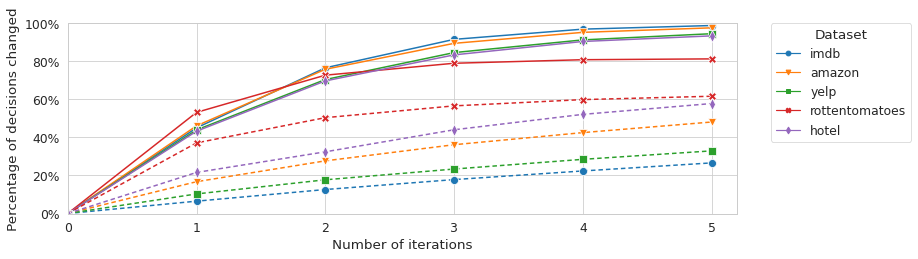

In [15]:
dash_param = [(3, 2) for i in range(5)]
markers = ['o', 'v', 's', 'X', 'd']
plt.figure(figsize=(12, 3.5))
sns.lineplot(x=phrases_col_name, y=flips_col_name, hue=dataset_col_name, data=df, dashes=False,
             style=dataset_col_name, linewidth=1.5, markersize=8, markers=markers)
sns.lineplot(x=phrases_col_name, y=flips_col_name, hue=dataset_col_name, data=df_random, dashes=dash_param,
             style=dataset_col_name, linewidth=1.5, markersize=8, legend=False, markers=markers)
plt.ylim(0, 100)
plt.xlim(0, 5.2)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())

plt.legend(title=dataset_col_name, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fidelity_line.png', bbox_inches='tight', dpi=300)